#### Antes de comenzar introduzca el path para trabajar en forma colaborativa

In [1]:
import os
if 'ndalessandro' in os.getcwd():
    path = r'C:\Users\ndalessandro\Desktop\UOC_Movies-Project-master/'
if 'yourMAC/Windowuser' in os.getcwd():
    path = 'yourPath'

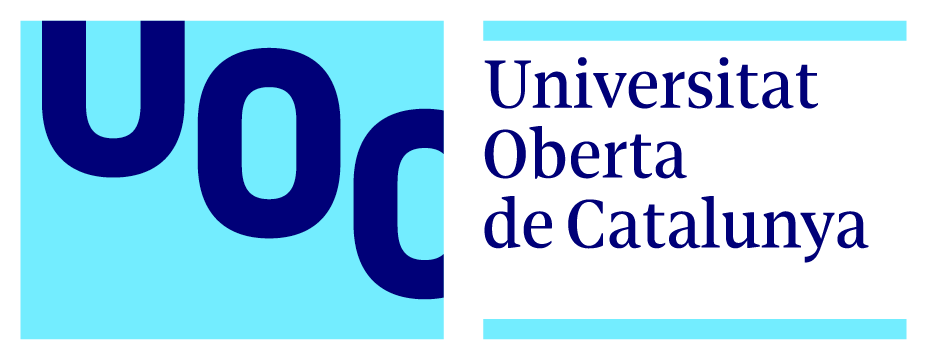

In [2]:
from IPython.display import Image
Image(filename= path + 'UOC1.png', width = 300)

# Desenvolupament Big Data PQTM 19 

## Python Project

**Alumnos:** Nicolás D'Alessandro y Daniel Benitez García

Para la creación de sistemas de recomendación podemos utilizar dos métodos:
    
    1 - Podemos recomendar los items más populares entre todos los usuarios.
    2 - Podemos dividir a los usuarios en segmentos(cluster) en función de sus preferencias y recomendarles items en función
    del segmento al que pertenecen.
        
Para comenzar nuestro proyecto, considerando que la segunda opción puede ser muy útil desde una perspectiva de negocio, trabajaremos sobre nuestro dataset para observar si existen clusters marcados que nos indiquen que merezca la pena segmentar nuestros usuarios (previo a desarrollar el algoritmo de recomendación).

 

### 00 - Importamos las librerías necesarias para nuestro trabajo

In [3]:
import pandas as pd
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### 01 - Establecemos nuestro entrono de trabajo "workbench"

####   1A - Creamos las clases y funciones necesarias

In [4]:
class DataEngineering:
    '''
    This class implements several functions that allow us to work specifically this task
    '''
    def __init__(self,path):
        self.path = ''
    def get_datasets(self):
        """
        This function returns the datasets rating and movies:
        >> Parameter 1 = Folder path
        -----------------------------------------
        << Return = length of ratings and movies datasets
        """
        self.path = path
        ratings_data = pd.read_csv(path + 'ratings.csv', sep=",", encoding="utf-8")
        movies_data  = pd.read_csv(path + 'movies.csv',  sep=",", encoding="utf-8")

        print('The dataset contains: ', len(ratings_data), ' ratings of ', len(movies_data), ' movies.')
        return ratings_data,movies_data
        
        
    def getGenres(self,data):
    
        """
        This Function returns all the genres available in our data:
            >> Parameter 1: 'movies' dataset
            -----------------------------------------
            << Return: List of all the genres in our dataset
        """
        self.data = data
    
        genres_list = []
        for line in data['genres']:
            uniques = line.split('|')
            for genre in uniques:
                if genre not in genres_list:
                    genres_list.append(genre)
        return genres_list
    

    def getRatingsByGenre(self, ratings, movies, genres):
        
        """
        This Function returns a DataFrame with the average ratings by genre grouped by user:
            >> Parameter 1: 'ratings' dataset
            >> Parameter 2: 'movies' dataset
            >> Parameter 3: [list] Genres we want to include
            -----------------------------------------
            << Return: DataFrame containing only columns defined by user
        """
        genre_ratings = pd.DataFrame()
        for genre in genres:
            genre_movies = movies[movies['genres'].str.contains(genre)]
            avg_genre_votes_per_user = \
                ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])[
                    'rating'].mean().round(2)

            genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)


        genre_ratings.columns = genres
        if '(no genres listed)' in genre_ratings:
            return genre_ratings.drop(columns = '(no genres listed)')
        else:
            return genre_ratings

### 02 - Importamos la data y comenzamos a trabajar en ella

#### 2A - Instanciamos la clase

In [5]:
data_engineering = DataEngineering(path)

#### 2B - Leemos los datasets

In [6]:
help(data_engineering.get_datasets)  # mediante la función help() podremos obtener la descripción de las funciones creadas

Help on method get_datasets in module __main__:

get_datasets() method of __main__.DataEngineering instance
    This function returns the datasets rating and movies:
    >> Parameter 1 = Folder path
    -----------------------------------------
    << Return = length of ratings and movies datasets



In [7]:
ratings, movies = data_engineering.get_datasets()

The dataset contains:  100836  ratings of  9742  movies.


#### 2C - Buscamos las 'features' disponobles (en este caso "generos de películas" en nuestro dataset)

In [8]:
genre_list = data_engineering.getGenres(movies)
print(genre_list)

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)']


#### 2D - Generamos un dataset con el promedio de rankings de cada usuario para cada género

In [9]:
warnings.filterwarnings("ignore", 'This pattern has match groups') #dado el tamaño del dataset utilizaremos este 'warning'
df = data_engineering.getRatingsByGenre(ratings,movies,genre_list)
df.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
1,4.39,4.69,4.55,4.28,4.30,4.31,4.53,4.32,4.36,4.15,3.47,4.17,4.22,4.50,4.68,NaN,NaN,4.29,5.0
2,4.17,NaN,NaN,4.00,NaN,4.50,3.88,3.95,3.80,3.70,3.00,4.00,3.88,4.50,NaN,4.33,3.75,3.50,NaN
3,2.73,0.50,0.50,1.00,3.38,0.50,0.75,3.57,0.50,4.14,4.69,5.00,4.20,0.50,0.50,NaN,NaN,NaN,NaN
4,3.66,4.00,3.80,3.51,3.68,3.38,3.48,3.32,3.81,3.55,4.25,3.48,2.83,3.57,4.00,4.00,3.00,3.80,4.0
5,3.25,4.33,4.11,3.47,4.14,3.09,3.80,3.11,3.83,3.56,3.00,4.00,2.50,3.33,4.40,NaN,3.67,3.00,NaN


#### 2E - Visualizamos nuestra data en forma de Heatmap

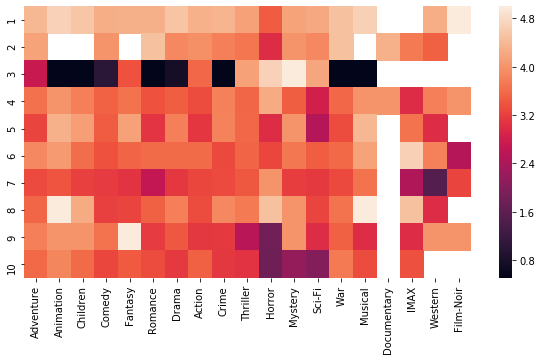

In [10]:
dims = (10, 5)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(ax=ax, data=df[0:10])   # ejemplo con los primeros 10 usuarios

### 03 - Realizaremos un poco de scripting para observar si hay clusteres marcados en nuestros datos.

* Utilizaremos el método K-Means (unsupervised ML) para clusterizar nuestra cartera de usuarios.

#### 3A - Normalizamos los datos y tratamos los valores nulos

In [11]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns).round(2)
df = df.fillna(0) #completamos los valores nulos con "0" (siendo que el usuario no consume películas del género)
df.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1.30,1.32,1.31,1.31,1.05,1.07,1.46,1.28,0.95,0.86,0.02,0.58,1.01,0.88,1.37,0.00,0.00,0.81,1.47
1,0.93,0.00,0.00,0.79,0.00,1.37,0.23,0.66,0.07,0.12,-0.54,0.34,0.51,0.88,0.00,0.64,-0.07,-0.18,0.00
2,-1.49,-3.96,-3.69,-4.71,-0.27,-5.00,-5.67,0.02,-5.17,0.85,1.46,1.76,0.98,-4.73,-3.90,0.00,0.00,0.00,0.00
3,0.07,0.45,0.38,-0.11,0.16,-0.41,-0.52,-0.40,0.08,-0.12,0.94,-0.40,-1.03,-0.42,0.52,0.26,-1.07,0.20,0.19
4,-0.62,0.87,0.77,-0.18,0.82,-0.87,0.08,-0.75,0.11,-0.11,-0.54,0.34,-1.51,-0.76,1.02,0.00,-0.18,-0.80,0.00


#### 3B - Realizamos PCA para poder visualizar los datos en dos dimensiones

In [12]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df.dropna())
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [13]:
pca.explained_variance_ratio_     #podemos observar que hemos perdido varianza, 
                                  #sin embargo a modo de ejercicio continuaremos con el análisis.

array([0.49142541, 0.08894957])

#### 3C - Graficamos ambas dimensiones para observar si hay clusters 

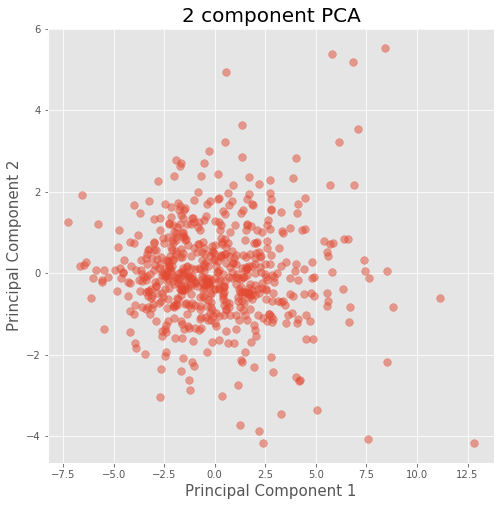

In [14]:
plt.style.use('ggplot')

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
           s = 60,
           alpha = 0.5)
ax.grid(True)

#### 3D - Seleccionamos el mejor numeo de K utilizando "elbow method" con 'Distortion' y 'Inertia'

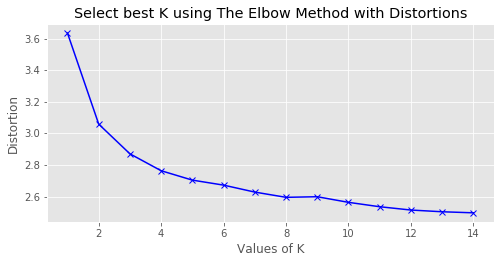

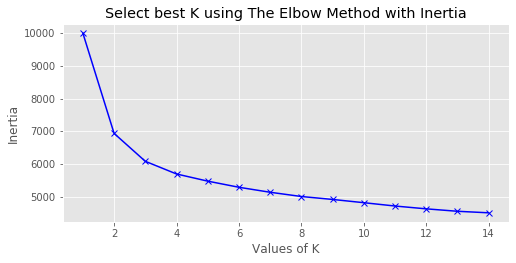

In [15]:
distortions = [] 
inertias = [] 
k_range = range(1,15) 
  
for k in k_range:  
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)     
      
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
    
plt.style.use('ggplot')

fig0 = plt.figure(figsize=(8, 8))
ax0 = fig0.add_subplot(211)

ax0.plot(k_range, distortions, 'bx-') 
ax0.set_title('Select best K using The Elbow Method with Distortions') 
ax0.set_xlabel('Values of K') 
ax0.set_ylabel('Distortion') 
plt.show() 

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(211)

ax1.plot(k_range, inertias, 'bx-') 
ax1.set_title('Select best K using The Elbow Method with Inertia') 
ax1.set_xlabel('Values of K') 
ax1.set_ylabel('Inertia') 
plt.show() 

## RESUMEN: Luego de realizar diversos análisis en nuestro dataset, podemos concluir que no hay evidencias significativas que justifiquen realizar clusterización, sin embargo, y a modo de mostrar el ejercicio, explicaremos brevemente como seguiría nuestro procedimiento.

### 04 - Realizamos K-means con el numero de cluster seleccionado (k = 4)

In [16]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(principalDf)
Centers = kmeans.cluster_centers_
predictions = kmeans.predict(principalDf)

#### 4A - Agregamos a nuestro dataset el grupo(cluster) al que nuestro algoritmo ha asignado a cada usuario, para poder realizar la recomendación dentro de cada cluster. 

In [17]:
df = pd.concat([principalDf.reset_index(), pd.DataFrame({'Group': predictions})], axis=1)

#### 4B - Graficamos los cluster

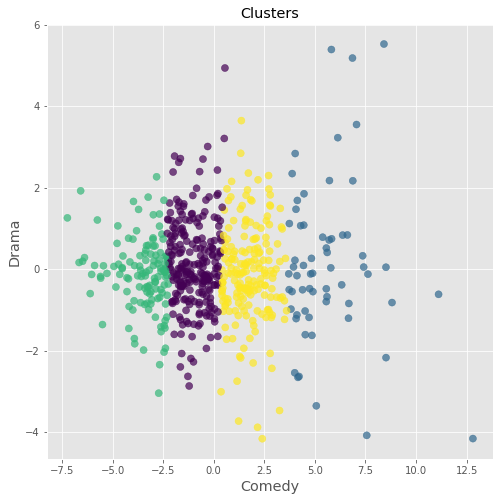

In [18]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.set_title('Clusters')
ax.set_xlabel('Comedy', fontsize =  'x-large')
ax.set_ylabel('Drama', fontsize =  'x-large')

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = df['Group'], s=50, alpha = 0.7)

#### 4C - Para finalizar volvemos a cargar los dataset y vemos como podríamos filtrarlos para trabajarlo por clusters/grupos. (ejemplo con el grupo número 2)

In [19]:
ratings_data = pd.read_csv(path + 'ratings.csv', sep=",", encoding="utf-8")
movies_data  = pd.read_csv(path + 'movies.csv',  sep=",", encoding="utf-8")

In [20]:
df = df.rename(columns= {'index' : 'userId'})   #cambiamos el nombre de la columna para poder hacer el join entre datasets
df.head()

,userId,principal component 1,principal component 2,Group
0,0,-4.183765,-0.916423,2
1,1,-1.479384,0.015031,0
2,2,8.415326,5.526007,1
3,3,0.457249,-0.784905,3
4,4,0.633990,-1.720871,3


In [21]:
merge_data = pd.merge(ratings_data, movies_data, on='movieId').drop(['movieId', 'timestamp'], axis=1)
merge_data = pd.merge(merge_data, df, on='userId').drop(['principal component 1', 'principal component 2'], axis=1)
merge_data.head()

,userId,rating,title,genres,Group
0,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0
1,1,4.0,Grumpier Old Men (1995),Comedy|Romance,0
2,1,4.0,Heat (1995),Action|Crime|Thriller,0
3,1,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0
4,1,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0


In [22]:
df_group2 = merge_data[merge_data.Group == 2]
df_group2.head()

,userId,rating,title,genres,Group
2976,44,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2
2977,44,3.0,Grumpier Old Men (1995),Comedy|Romance,2
2978,44,3.0,Heat (1995),Action|Crime|Thriller,2
2979,44,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,2
2980,44,3.0,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,2
